### 1.Setup & Data Loading

In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import sys
sys.path.append(os.path.abspath('..'))
import config 

# --- CONFIGURATION (Adjust these paths for your local machine) ---
DATA_BASE_PATH = os.path.join(config.DATASPACE, "TMA_Cores_Grouped_NEW")
# core
INPUT_FOLDER = os.path.join(DATA_BASE_PATH, "Core_17")
CK_CHANNEL_IDX = 6

# Helper to load specific slices
def get_slice_number(filename):
    match = re.search(r"TMA_(\d+)_", os.path.basename(filename))
    return int(match.group(1)) if match else 0

# Load file list
raw_files = glob.glob(os.path.join(INPUT_FOLDER, "*.ome.tif"))
file_list = sorted(raw_files, key=get_slice_number)

print(f"Found {len(file_list)} slices.")

# --- VISUALIZATION HELPER ---
def show_overlay(fixed, moving, title="Overlay"):
    """
    Simple overlay viewer for notebook.
    Red = Fixed, Green = Moving
    """
    f_arr = sitk.GetArrayFromImage(fixed)
    m_arr = sitk.GetArrayFromImage(moving)
    
    # Simple Normalize 
    f_norm = f_arr / (f_arr.max() + 1e-6)
    m_norm = m_arr / (m_arr.max() + 1e-6)
    
    rgb = np.dstack((f_norm, m_norm, np.zeros_like(f_norm)))
    
    plt.figure(figsize=(8,8))
    plt.imshow(np.clip(rgb, 0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()

# LOAD TWO PROBLEMATIC SLICES (e.g., Z4 and Z5 from your image)
# Adjust indices [4] and [5] if your file sorting is different
fixed_img_full = sitk.ReadImage(file_list[11]) 
moving_img_full = sitk.ReadImage(file_list[12])

print(f"Loaded Slice {get_slice_number(file_list[11])} (Fixed) and Slice {get_slice_number(file_list[12])} (Moving)")

Found 20 slices.
Loaded Slice 12 (Fixed) and Slice 13 (Moving)


In [11]:
# --- 1. DATA STANDARDIZATION ---
# Goal: Create a single set of input images (Downsampled x16) to be used by ALL experiments.

# Constants
SHRINK_FACTOR = 4
SAMPLING_PERC = 0.50
CK_CHANNEL = 6  # Adjust if needed based on your config

def prepare_base_images(fixed_full, moving_full, channel_idx, shrink_factor):
    """
    Extracts channel, casts to Float32, and explicitly shrinks the image.
    This ensures every optimizer sees exactly the same pixel grid.
    """
    # 1. Extract Channel & Cast
    fixed_float = sitk.Cast(fixed_full[:, :, channel_idx], sitk.sitkFloat32)
    moving_float = sitk.Cast(moving_full[:, :, channel_idx], sitk.sitkFloat32)
    
    # 2. Explicit Downsampling
    # We use sitk.Shrink (which updates physical spacing correctly)
    # instead of the internal multi-resolution pyramid.
    fixed_base = sitk.Shrink(fixed_float, [shrink_factor] * 2)
    moving_base = sitk.Shrink(moving_float, [shrink_factor] * 2)
    
    print(f"Base Images Prepared:")
    print(f" - Original Size: {fixed_full.GetSize()}")
    print(f" - Shrunk Size:   {fixed_base.GetSize()} (Factor: {shrink_factor})")
    
    return fixed_base, moving_base

# Execute
fixed_base, moving_base = prepare_base_images(fixed_img_full, moving_img_full, CK_CHANNEL, SHRINK_FACTOR)

Base Images Prepared:
 - Original Size: (6112, 6112, 8)
 - Shrunk Size:   (1528, 1528) (Factor: 4)


### 2.The Registration Factory

In [15]:
# --- 2. MODULAR REGISTRATION FACTORY ---

def run_standardized_registration(fixed, moving, optimizer_name, metric_name):
    """
    Runs a registration with fixed sampling/interpolation constraints.
    Only Optimizer and Metric change.
    """
    # Initialize Transform (Geometry Center)
    initial_tx = sitk.CenteredTransformInitializer(
        fixed, moving, 
        sitk.Euler2DTransform(), 
        #sitk.CenteredTransformInitializerFilter.GEOMETRY
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    
    reg = sitk.ImageRegistrationMethod()
    
    # A. METRIC CONFIGURATION
    if metric_name == "Mattes":
        reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    elif metric_name == "MeanSquares":
        reg.SetMetricAsMeanSquares()
    else:
        raise ValueError(f"Unknown Metric: {metric_name}")
        
    # B. SAMPLING CONFIGURATION (FIXED)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(SAMPLING_PERC)
    
    # C. OPTIMIZER CONFIGURATION
    if optimizer_name == "OnePlusOne":
        reg.SetOptimizerAsOnePlusOneEvolutionary(
            numberOfIterations=300, epsilon=1e-6, 
            initialRadius=1.5, growthFactor=1.1, shrinkFactor=0.9
        )
    elif optimizer_name == "RegularStepGradient":
        reg.SetOptimizerAsRegularStepGradientDescent(
            learningRate=1.0, minStep=0.001, numberOfIterations=200
        )
    elif optimizer_name == "LBFGSB":
        reg.SetOptimizerAsLBFGSB(
            gradientConvergenceTolerance=1e-5, numberOfIterations=200,
            maximumNumberOfCorrections=5, maximumNumberOfFunctionEvaluations=1000,
            costFunctionConvergenceFactor=1e+7
        )
    elif optimizer_name == "Amoeba":
        reg.SetOptimizerAsAmoeba(simplexDelta=2.0, numberOfIterations=200)
    else:
        raise ValueError(f"Unknown Optimizer: {optimizer_name}")

    # D. PYRAMID CONFIGURATION
    # Since inputs are PRE-SHRUNK, we use a single level [1] here.
    reg.SetShrinkFactorsPerLevel([1])
    reg.SetSmoothingSigmasPerLevel([0])
    reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
    
    reg.SetInitialTransform(initial_tx)
    reg.SetInterpolator(sitk.sitkLinear)
    
    # Execute
    try:
        final_tx = reg.Execute(fixed, moving)
        final_metric = reg.GetMetricValue()
        stop_condition = reg.GetOptimizerStopConditionDescription()
        return {
            "transform": final_tx,
            "metric_val": final_metric,
            "stop_cond": stop_condition,
            "status": "Success"
        }
    except Exception as e:
        return {
            "transform": initial_tx,
            "metric_val": np.nan,
            "stop_cond": str(e),
            "status": "Failed"
        }

### Execution Loop & Visualization

Optimizer                 | Metric          | Value      | Status
----------------------------------------------------------------------
OnePlusOne                | Mattes          | -0.0149     | Success
OnePlusOne                | MeanSquares     | 477.4424     | Success
RegularStepGradient       | MeanSquares     | 485.0098     | Success
LBFGSB                    | MeanSquares     | 501.8393     | Success
Amoeba                    | MeanSquares     | 474.8649     | Success
Amoeba                    | Mattes          | -0.0156     | Success


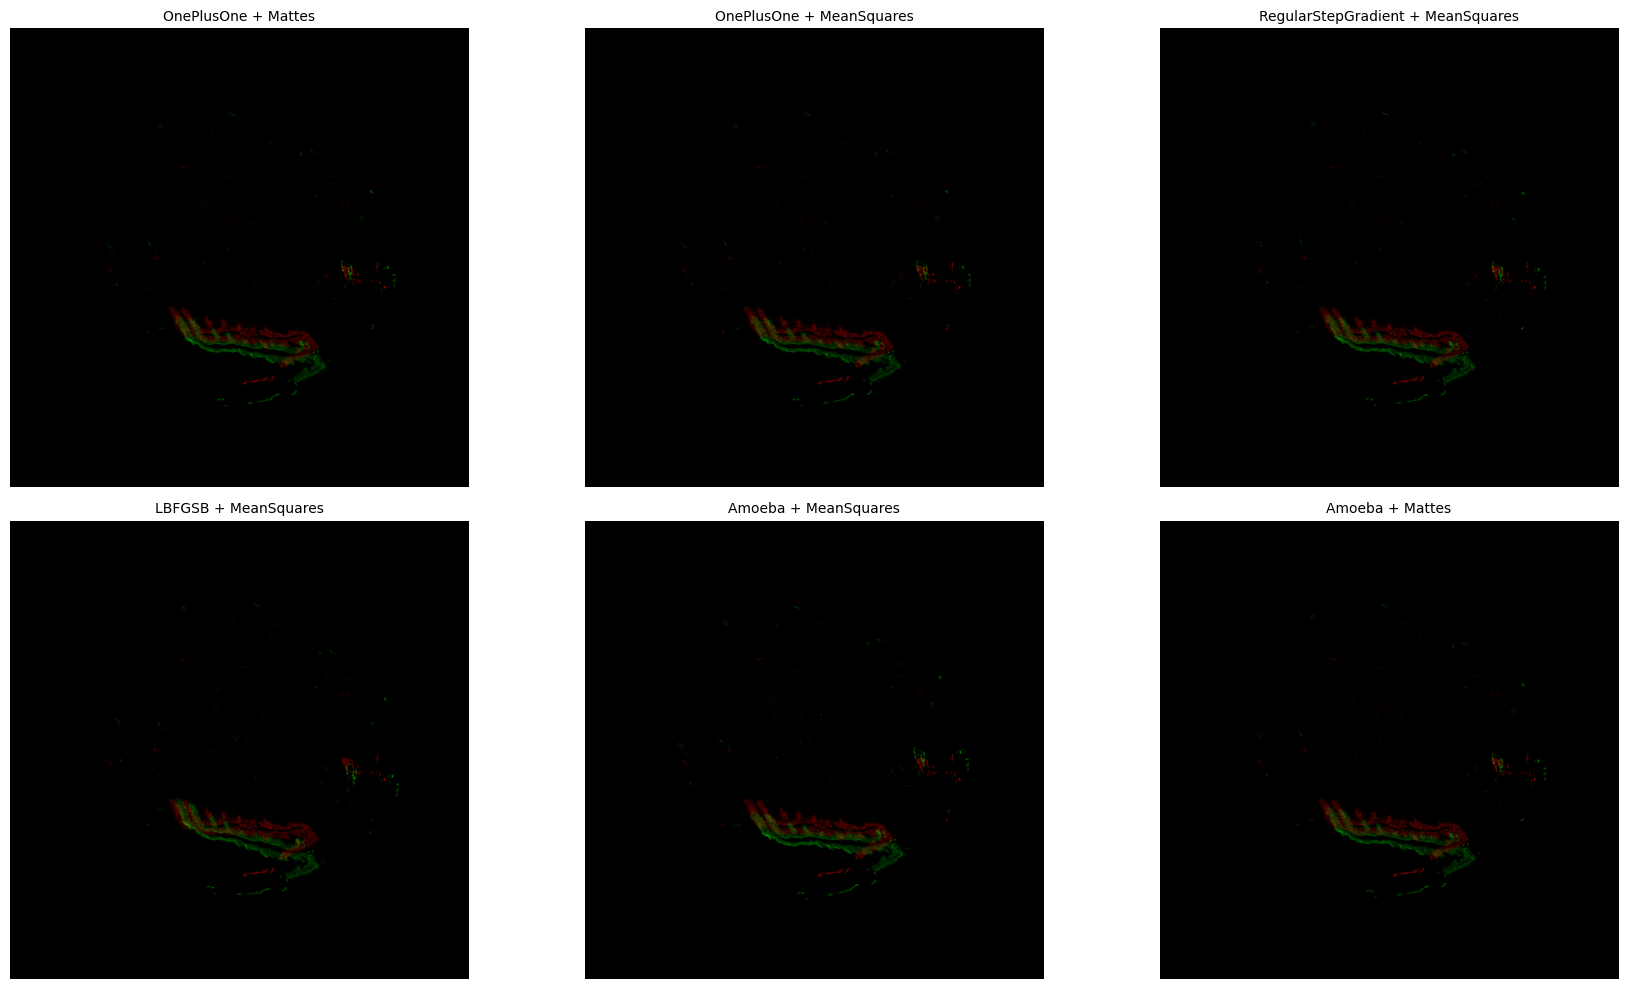

In [16]:
import pandas as pd # Optional, for clean results table

# --- 3. EXPERIMENT RUNNER ---

# Define the matrix of experiments
experiments = [
    ("OnePlusOne", "Mattes"),
    ("OnePlusOne", "MeanSquares"),
    ("RegularStepGradient", "MeanSquares"), # Gradient usually prefers MeanSquares or Correlation
    ("LBFGSB", "MeanSquares"),
    ("Amoeba", "MeanSquares"),
    ("Amoeba", "Mattes")
]

results_data = []
vis_results = {}

print(f"{'Optimizer':<25} | {'Metric':<15} | {'Value':<10} | {'Status'}")
print("-" * 70)

for opt, met in experiments:
    # Run Factory
    res = run_standardized_registration(fixed_base, moving_base, opt, met)
    
    # Log Data
    print(f"{opt:<25} | {met:<15} | {res['metric_val']:.4f}     | {res['status']}")
    
    results_data.append({
        "Optimizer": opt,
        "Metric": met,
        "Final Value": res['metric_val'],
        "Status": res['status'],
        "Stop Condition": res['stop_cond']
    })
    
    # Store transform for plotting
    key = f"{opt} + {met}"
    vis_results[key] = res['transform']

# --- 4. VISUALIZATION ---
# Plotting the overlays
cols = 3
rows = (len(experiments) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

# Helper for visualization
def simple_overlay(ax, fixed, moving, tx, title):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetTransform(tx)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    
    moved = resampler.Execute(moving)
    
    f_arr = sitk.GetArrayFromImage(fixed)
    m_arr = sitk.GetArrayFromImage(moved)
    
    # Normalize
    f_arr = f_arr / (f_arr.max() + 1e-6)
    m_arr = m_arr / (m_arr.max() + 1e-6)
    
    rgb = np.dstack((f_arr, m_arr, np.zeros_like(f_arr)))
    ax.imshow(np.clip(rgb, 0, 1))
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Plot Loop
for i, (key, tx) in enumerate(vis_results.items()):
    simple_overlay(axes[i], fixed_base, moving_base, tx, key)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()